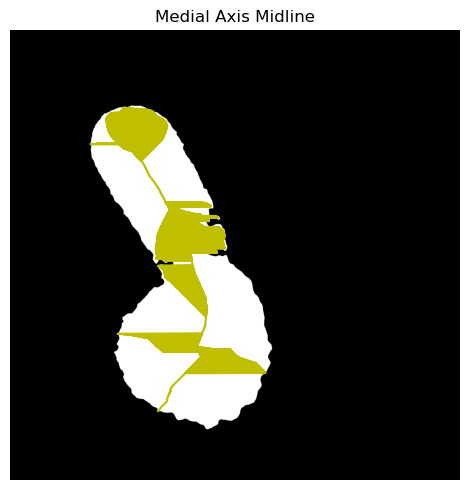

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, morphology

# === Step 1: Load binary mask ===
image_path = "/Users/ericayliu/Bowling Lab/091624_gastruloids_092524_120h_HM_A005_ch00.tif"
binary = io.imread(image_path) > 0  # ensure it's boolean (in case it's 0-255)

# === Step 2: Compute medial axis ===
medial_axis = morphology.medial_axis(binary)
xM, yM = np.nonzero(medial_axis)  # Extract coordinates of midline pixels

# === Step 3: Plot result ===
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(binary, cmap='gray')     # Show binary mask as background
ax.plot(yM, xM, c='y')             # Overlay medial axis in yellow
ax.set_title("Medial Axis Midline")
ax.axis("off")
plt.tight_layout()
plt.show()

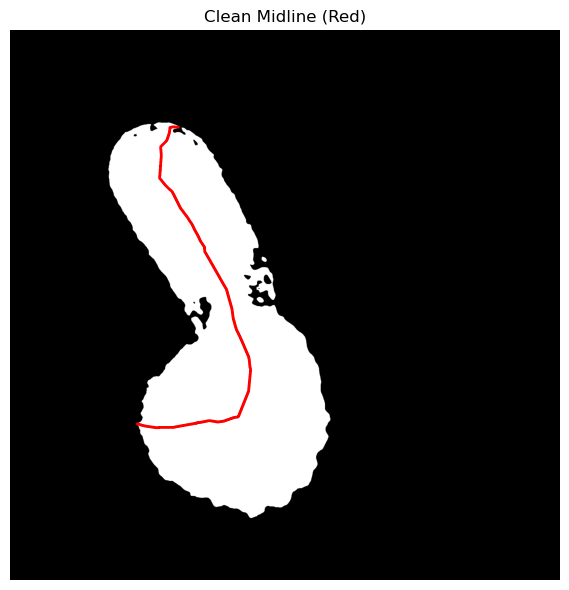

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, morphology
import networkx as nx

# === Load binary mask ===
image_path = "/Users/ericayliu/Bowling Lab/091624_gastruloids_092524_120h_HM_A005_ch00.tif"
binary = io.imread(image_path) > 0  # Make sure it's boolean

# === Compute medial axis (skeleton)
skeleton = morphology.medial_axis(binary)

# === Convert skeleton to graph ===
def skeleton_to_graph(skel):
    G = nx.Graph()
    rows, cols = np.nonzero(skel)
    for y, x in zip(rows, cols):
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dy == 0 and dx == 0:
                    continue
                ny, nx_ = y + dy, x + dx
                if 0 <= ny < skel.shape[0] and 0 <= nx_ < skel.shape[1]:
                    if skel[ny, nx_]:
                        G.add_edge((y, x), (ny, nx_))
    return G

G = skeleton_to_graph(skeleton)

# === Find endpoints ===
endpoints = [n for n in G.nodes if G.degree(n) == 1]

# === Find longest shortest path between endpoints ===
max_length = 0
longest_path = []
for i in range(len(endpoints)):
    for j in range(i + 1, len(endpoints)):
        try:
            path = nx.shortest_path(G, source=endpoints[i], target=endpoints[j])
            if len(path) > max_length:
                max_length = len(path)
                longest_path = path
        except nx.NetworkXNoPath:
            continue

# === Plot ===
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(binary, cmap='gray')

if longest_path:
    y_path, x_path = zip(*longest_path)
    ax.plot(x_path, y_path, 'r-', linewidth=2, label="Midline")

ax.set_title("Clean Midline")
ax.axis("off")
plt.tight_layout()
plt.show()

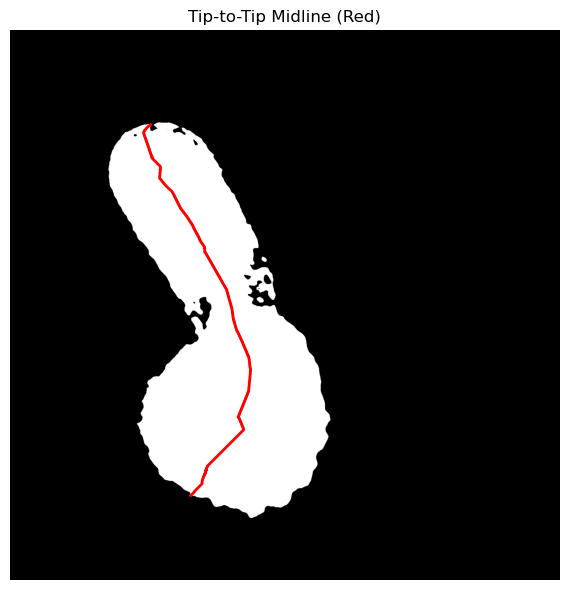

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, morphology
import networkx as nx
from scipy.spatial.distance import pdist, squareform

# === Load binary mask image ===
image_path = "/Users/ericayliu/Bowling Lab/091624_gastruloids_092524_120h_HM_A005_ch00.tif"
binary = io.imread(image_path) > 0  # Ensure binary (in case it’s 0–255)

# === Compute skeleton (medial axis) ===
skeleton = morphology.medial_axis(binary)

# === Convert skeleton to graph ===
def skeleton_to_graph(skel):
    G = nx.Graph()
    rows, cols = np.nonzero(skel)
    for y, x in zip(rows, cols):
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dy == 0 and dx == 0:
                    continue
                ny, nx_ = y + dy, x + dx
                if 0 <= ny < skel.shape[0] and 0 <= nx_ < skel.shape[1]:
                    if skel[ny, nx_]:
                        G.add_edge((y, x), (ny, nx_))
    return G

G = skeleton_to_graph(skeleton)

# === Find endpoints (nodes with only one connection) ===
endpoints = [n for n in G.nodes if G.degree(n) == 1]

# === Find the two endpoints that are farthest apart (Euclidean distance) ===
endpoints_array = np.array(endpoints)
dists = squareform(pdist(endpoints_array))
i, j = np.unravel_index(np.argmax(dists), dists.shape)
start, end = endpoints[i], endpoints[j]

# === Find shortest path along the skeleton between these two endpoints ===
try:
    longest_path = nx.shortest_path(G, source=start, target=end)
except nx.NetworkXNoPath:
    longest_path = []

# === Plot result ===
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(binary, cmap='gray')
if longest_path:
    y_path, x_path = zip(*longest_path)
    ax.plot(x_path, y_path, 'r-', linewidth=2, label='Midline')
ax.set_title("Tip-to-Tip Midline")
ax.axis("off")
plt.tight_layout()
plt.show()
